In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot
!pip install neptune-cli

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([
    
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(
        brightness=abs(float(0.1*torch.randn(1))),
        contrast=abs(float(0.1*torch.randn(1))),
        saturation=abs(float(0.1*torch.randn(1))),
        hue=abs(float(0.1*torch.randn(1)))),
        torchvision.transforms.ToTensor(),
     ])),
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation((-60,60)),torchvision.transforms.ToTensor(),
     ])),
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=1),torchvision.transforms.ToTensor(),
     ])),
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
     ])),
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),

        ]),
    shuffle=True, batch_size=16, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=16, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 210000
> Size of test dataset 10000


**View some of the test dataset**

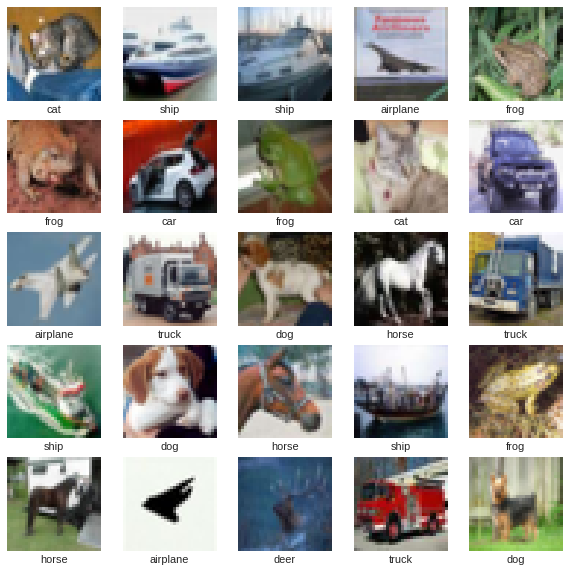

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [5]:
# define the model (a simple autoencoder) 
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        self.encodelist = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,64,kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decodelist = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,2,1,1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,16,3,2,1,1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,3,1,1,bias=False),
            nn.ReLU()
        )
        self.lin_encode=nn.Linear(8*8*128,1000)
        
        self.lin_decode=nn.Linear(1000,8*8*128)
        
        
        
    def forward(self, x):
        z = self.encode(x)
        
        x = self.decode(z)
        return x

    # encode (flatten as linear, then run first half of network)
    def encode(self, x):
        x = self.encodelist(x)
        x = x.view(x.size(0), -1)
        x=self.lin_encode(x)
        return x

    # decode (run second half of network then unflatten)
    def decode(self, x):
        x=self.lin_decode(x)
        x = x.view(x.size(0), 128, 8, 8)
        x=self.decodelist(x)
        
        return x

N = MyNetwork().to(device)

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0
liveplot = PlotLosses()

> Number of network parameters 16560520


**Main training loop**

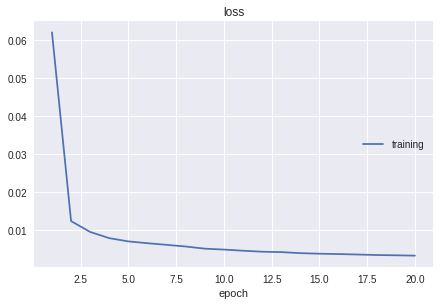

loss:
training   (min:    0.003, max:    0.062, cur:    0.003)


In [6]:
# training loop, feel free to also train on the test dataset if you like for generating the pegasus
while (epoch<20):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        loss = ((p-x)**2).mean() # simple l2 loss
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)

    # NOTE: live plot library has dumb naming forcing our 'test' to be called 'validation'
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus by interpolating between the latent space encodings of a horse and a bird**

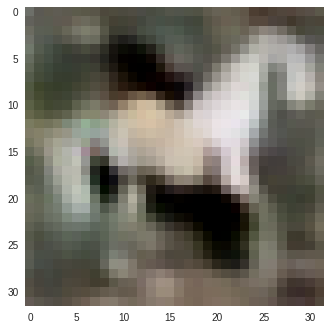

In [11]:
horse = test_loader.dataset[13][0].to(device)  # horse
bird = test_loader.dataset[160][0].to(device) # bird

horsecode = N.encode(horse.unsqueeze(0))
birdcode = N.encode(bird.unsqueeze(0))

# this is some sad blurry excuse of a Pegasus, hopefully you can make a better one
weird_pegasus = N.decode(0.6*horsecode + 0.4*birdcode).squeeze(0)

plt.grid(False)
plt.imshow(weird_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))